In [22]:
import hashlib
import pandahouse
import pandas as pd
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import numpy as np

## Exericise 3 (Linearization - groups 0 vs 3, groups 1 (test) vs 2(control))

In [23]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

### сравнение групп 1 и 2

In [24]:
q_ctr = '''SELECT user_id, exp_group, countIf(action='like') likes, countIf(action='view') views, countIf(action='like')/countIf(action='view') ctr
from simulator_20220520.feed_actions 
group by user_id, exp_group
having toDate(time)>='2022-04-24' and toDate(time)<='2022-04-30' and exp_group in (1,2) 
'''

In [25]:
df_ctr = pandahouse.read_clickhouse(query=q_ctr, connection=connection)

In [26]:
df_ctr['exp_group'].replace(1,'control', inplace=True)
df_ctr['exp_group'].replace(2,'test', inplace=True)
df_ctr_tst = df_ctr[df_ctr['exp_group']=='test']
df_ctr_ctrl = df_ctr[df_ctr['exp_group']=='control']

In [27]:
sns.set(rc={'figure.figsize':(10,5)})

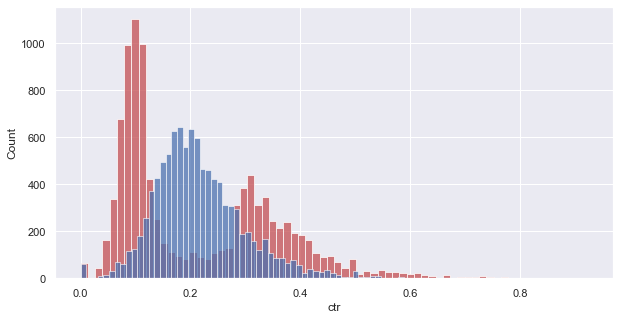

In [28]:
# тестовая выборка с двумя горбами
sns.histplot(df_ctr_tst.ctr, color='r', bins=70)
sns.histplot(df_ctr_ctrl.ctr, color='b', bins=70);

In [29]:
# расчет глобального ctr в контрольной группе
global_ctr_ctrl = df_ctr_ctrl.likes.sum() / df_ctr_ctrl.views.sum()
# 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 dfsdf
df_ctr_ctrl['linearised_likes'] = df_ctr_ctrl.likes - global_ctr_ctrl*df_ctr_ctrl.views
df_ctr_tst['linearised_likes'] = df_ctr_tst.likes - global_ctr_ctrl*df_ctr_tst.views

/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_48179/3490817585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_ctrl['linearised_likes'] = df_ctr_ctrl.likes - global_ctr_ctrl*df_ctr_ctrl.views
/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_48179/3490817585.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_tst['linearised_likes'] = df_ctr_tst.likes - global_ctr_ctrl*df_ctr_tst.views


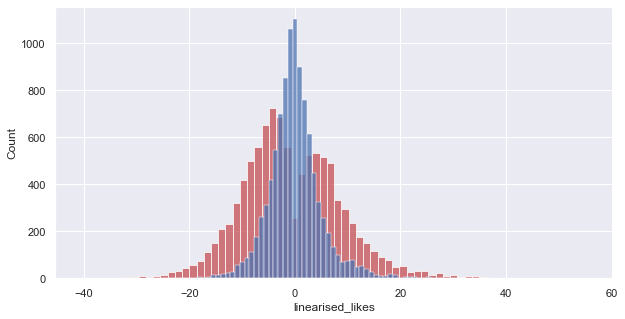

In [30]:
# два горба сохранились, но стали более сглаженными и сместились к центре
sns.histplot(df_ctr_tst.linearised_likes, color='r', bins=70)
sns.histplot(df_ctr_ctrl.linearised_likes, color='b', bins=70);

In [31]:
# на линеаризованных лайках t-test срабатывает
_, pvalue = stats.ttest_ind(df_ctr_tst.ctr, df_ctr_ctrl.ctr, equal_var=False)
_, pvalue_linear_likes = stats.ttest_ind(df_ctr_tst.linearised_likes, df_ctr_ctrl.linearised_likes, equal_var=False)
print(f'P-value t-теста для сырого ctr = {pvalue}, для сглаженного ctr = {pvalue_linear_likes}')

P-value t-теста для сырого ctr = 0.4780623130874935, для сглаженного ctr = 9.439432187037712e-10


**вывод1:**
- P-value t-теста для обычных ctr было сильно больше 0,05, то есть подтверждалась гипотеза о равенстве средних. 
- Для линеаризованных лайков гипотеза о равенстве средних не подтвердилась. 

### сравнение групп 0 и 3

In [32]:
q_ctr03 = '''SELECT user_id, exp_group, countIf(action='like') likes, countIf(action='view') views, countIf(action='like')/countIf(action='view') ctr
from simulator_20220520.feed_actions 
group by user_id, exp_group
having toDate(time)>='2022-04-24' and toDate(time)<='2022-04-30' and exp_group in (0,3) 
'''

In [33]:
df_ctr03 = pandahouse.read_clickhouse(query=q_ctr03, connection=connection)

In [34]:
df_ctr_0 = df_ctr03[df_ctr03['exp_group']==0]
df_ctr_3 = df_ctr03[df_ctr03['exp_group']==3]

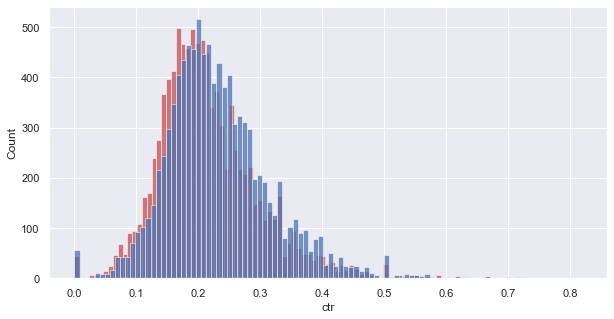

In [35]:
# визуально группа 0 немного сдвинута влево относительно группы 3. В обеих есть выбросы в районе 0 и 0,5. 
sns.histplot(df_ctr_0.ctr, color='r', bins=100)
sns.histplot(df_ctr_3.ctr, color='b', bins=100);

In [36]:
# расчет глобального ctr в контрольной группе
global_ctr_0 = df_ctr_0.likes.sum() / df_ctr_0.views.sum()
# 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 dfsdf
df_ctr_0['linearised_likes'] = df_ctr_0.likes - global_ctr_0*df_ctr_0.views
df_ctr_3['linearised_likes'] = df_ctr_3.likes - global_ctr_0*df_ctr_3.views

/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_48179/4267587032.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_0['linearised_likes'] = df_ctr_0.likes - global_ctr_0*df_ctr_0.views
/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_48179/4267587032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_3['linearised_likes'] = df_ctr_3.likes - global_ctr_0*df_ctr_3.views


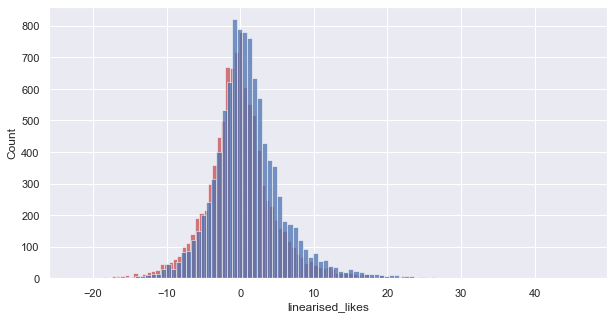

In [37]:
# обе выборки стали более сглаженными, но некоторое смещение влево группы 0 сохранилось
sns.histplot(df_ctr_0.linearised_likes, color='r', bins=100)
sns.histplot(df_ctr_3.linearised_likes, color='b', bins=100);

In [38]:
# для обоих вариантов т-тест прокрашивается. 
_, pvalue = stats.ttest_ind(df_ctr_0.ctr, df_ctr_3.ctr, equal_var=False)
_, pvalue_linear_likes = stats.ttest_ind(df_ctr_0.linearised_likes, df_ctr_3.linearised_likes, equal_var=False)
print(f'P-value t-теста для сырого ctr = {pvalue}, для сглаженного ctr = {pvalue_linear_likes}')

P-value t-теста для сырого ctr = 1.055849414662529e-43, для сглаженного ctr = 5.491424947968532e-52


**вывод2:**
- Для групп 0 и 3 P-value t-теста сильно меньше 0,05 уже на необработанных CTR, то есть гипотеза о равенстве средних не подтверждается. 
- Для линеаризованных лайков гипотеза о равенстве средних также не подтвердилась, p-value стал еще меньше.